In [29]:
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mave_calibration.skew_normal import density_utils
from main import load_data,singleFit,plot,draw_evidence_figure,fit_quality_figure
import numpy as np

In [3]:

dataset_id = "urn_mavedb_00000013-a-1"
observations = joblib.load(f"/mnt/d/mave_calibration/data/{dataset_id}/observations.pkl")

In [15]:
def makeData(sample_names):
    NSamples = len(sample_names)
    X = np.zeros((0,))
    S = np.zeros((0,NSamples),dtype=bool)
    for sample_name in sample_names:
        sample = observations[sample_name]
        X = np.concatenate((X, sample))
        si = np.zeros((len(sample), NSamples),dtype=bool)
        si[:,sample_names.index(sample_name)] = True
        S = np.concatenate((S, si))
    return X, S

In [21]:
sample_names_1 = ['pathogenic_missense','benign_missense','missense']
X1,S1 = makeData(sample_names_1)
sample_names_2 = ['pathogenic_missense','synonymous','missense']
X2,S2 = makeData(sample_names_2)

In [17]:
fit1 = singleFit(X1, S1)

  0%|          | 0/10 [00:00<?, ?it/s]

  2%|▏         | 165/10000 [00:05<05:26, 30.12it/s, likelihood=-0.147818]


In [18]:
fit2 = singleFit(X2, S2)

  3%|▎         | 258/10000 [00:08<05:32, 29.30it/s, likelihood=-0.133724]


In [35]:
def fit_quality_figure(X,S, sample_names, weights, component_params, sample_n_components,**kwargs):
    individual_fits = {}
    for i, sample_name in enumerate(sample_names):
        xs = X[S[:,i]]
        # for _ in range(100):
        #     try:
        #         p = singleFit(xs, np.ones((len(xs),1),dtype=bool),max_iters=10000,verbose=False)
        #     except Exception as e:
        #         print(e)
        #         continue
        #     break
        # try:
        #     individual_fits[sample_name] = p
        # except UnboundLocalError:
        #     try:
        #         individual_fits[sample_name] = singleFit(xs, np.ones((len(xs),1),dtype=bool),max_iters=10000, n_components=1,constrained=False,verbsose=False)
        #     except Exception as e:
        #         print(e)
        #         continue
        kwargs['n_components'] = sample_n_components[i]
        individual_fits[sample_name] = singleFit(xs, np.ones((len(xs),1),dtype=bool),max_iters=10000,constrained=False,verbsose=False,**kwargs)
    fig, ax = plt.subplots(2,3,figsize=(15,7))
    rng = np.arange(X.min() - .25,X.max() + .25 ,.01)
    fig,ax = plt.subplots(2,3,figsize=(15,7),sharey='row',sharex=True)
    for i, k in enumerate(sample_names):
        sns.histplot(X[S[:,i]],ax=ax[0,i],stat='density',alpha=.5)
        try:
            value = individual_fits[k]
        except KeyError:
            continue
        densities = density_utils.joint_densities(rng, value[0],value[1][0])
        multisample_densities = density_utils.joint_densities(rng, component_params, weights[i])
        P = densities.sum(0)
        Q = multisample_densities.sum(0)
        ax[0,i].plot(rng, Q,color='green', label='multi-sample fit')
        ax[0,i].plot(rng, P,color='orange',label='single-sample fit')
        ax[0,i].legend()
        ax[0,i].set_title(k)
        kl = P * np.log(P/Q)
        ax[1,i].plot(rng, kl,label=f"KL divergence {np.nansum(kl):.3f}")
        ax[1,i].legend()
        ax[1,i].set_xlabel("Assay Score")
    ax[1,0].set_ylabel("Relative Entropy")
    return fig,ax

In [36]:
fit_quality_figure(X1,S1,sample_names_1,fit1[0],fit1[1], [2,1,2])

TypeError: mave_calibration.initializations.constrained_gmm_init() got multiple values for keyword argument 'n_components'

(<Figure size 1000x1000 with 3 Axes>,
 array([<Axes: title={'center': 'Pathogenic Missense Variants'}>,
        <Axes: title={'center': 'Benign Missense Variants'}>,
        <Axes: title={'center': 'Missense Variants'}>], dtype=object))

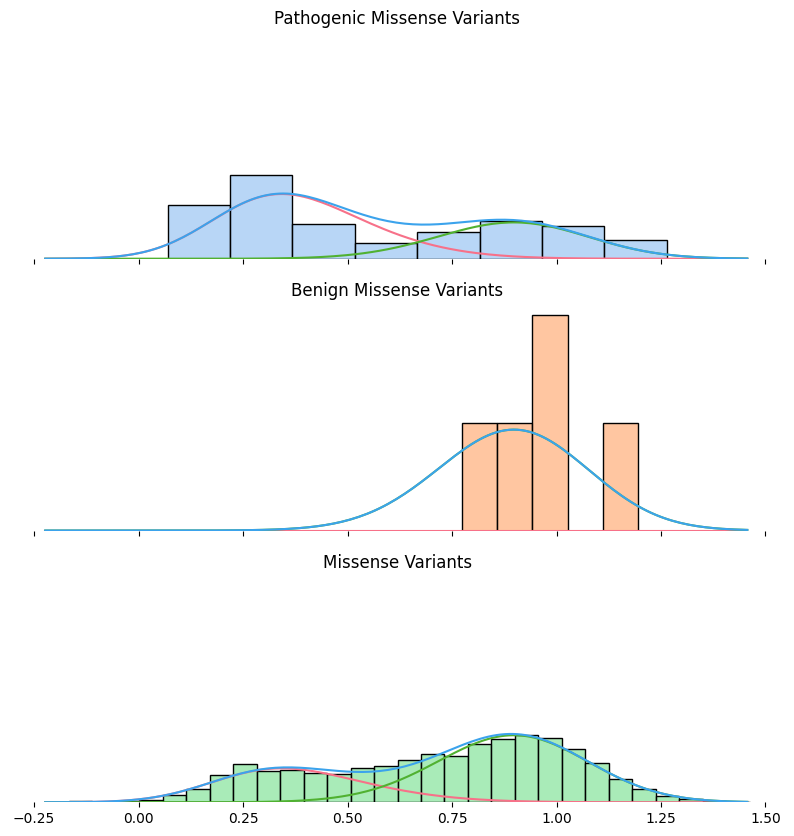

In [25]:
plot(X1,S1, sample_names_1,fit1[1],fit1[0])

(<Figure size 1000x1000 with 3 Axes>,
 array([<Axes: title={'center': 'Pathogenic Missense Variants'}>,
        <Axes: title={'center': 'Synonymous Variants'}>,
        <Axes: title={'center': 'Missense Variants'}>], dtype=object))

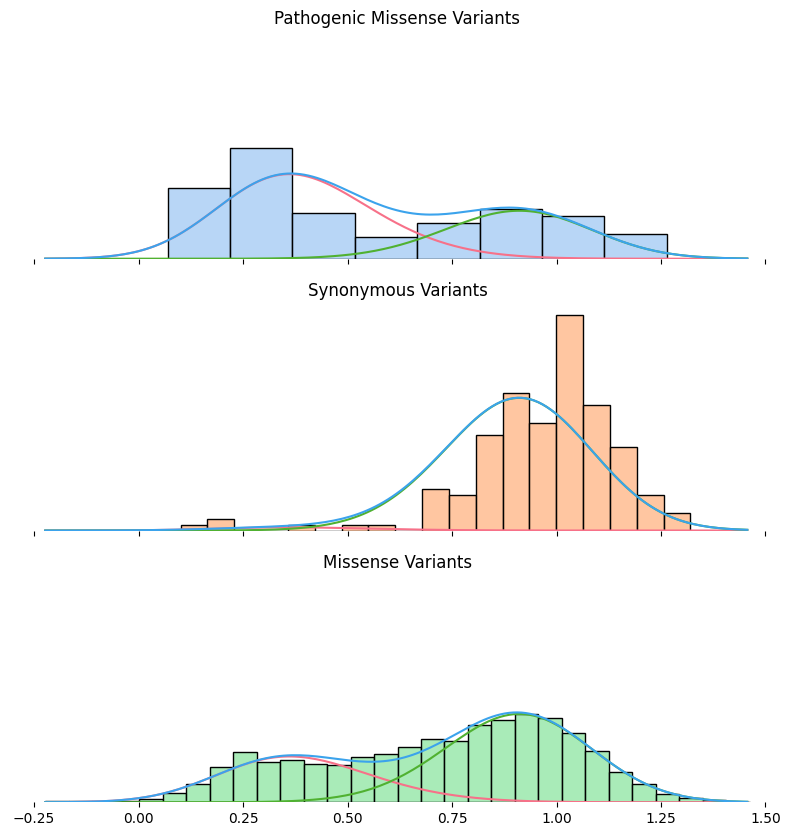

In [26]:
plot(X2,S2, sample_names_2,fit2[1],fit2[0])